In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
import tensorflow
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.datasets import mnist
from keras.optimizers import RMSprop,Adam

In [2]:
# from google.colab import files
# uploaded=files.upload()

In [3]:
data=pd.read_excel("Company stock prices.xlsx")

In [4]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-19,537.070007,541.799988,525.380005,530.719971,530.719971,7567500
1,2020-10-20,528.140015,533.780029,522.260010,525.419983,525.419983,10047200
2,2020-10-21,501.029999,506.850006,488.250000,489.049988,489.049988,17405700
3,2020-10-22,494.690002,495.140015,482.000000,485.230011,485.230011,6997900
4,2020-10-23,488.109985,490.059998,481.350006,488.279999,488.279999,4927900
...,...,...,...,...,...,...,...
748,2023-10-10,385.579987,388.700012,372.250000,373.320007,373.320007,7288900
749,2023-10-11,372.779999,377.809998,365.339996,365.929993,365.929993,9151400
750,2023-10-12,366.480011,368.829987,359.049988,361.200012,361.200012,7376100
751,2023-10-13,355.640015,358.929993,352.049988,355.679993,355.679993,6312600


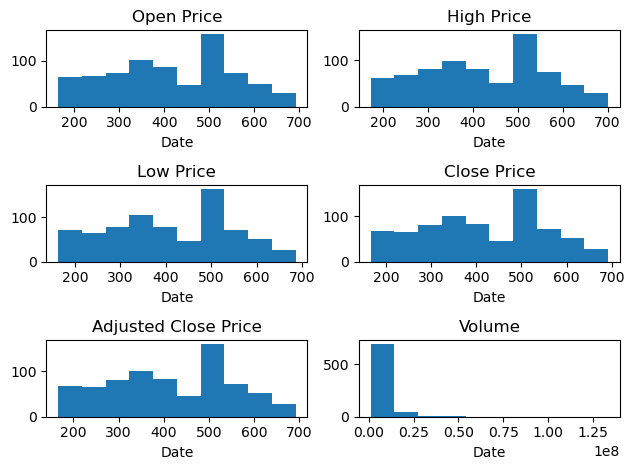

In [5]:
# Open
plt.subplot(3, 2, 1)
plt.hist(data['Open'])
plt.title('Open Price')
plt.xlabel('Date')

# High
plt.subplot(3, 2, 2)
plt.hist(data['High'])
plt.title('High Price')
plt.xlabel('Date')

# Low
plt.subplot(3, 2, 3)
plt.hist(data['Low'])
plt.title('Low Price')
plt.xlabel('Date')

# Close
plt.subplot(3, 2, 4)
plt.hist(data['Close'])
plt.title('Close Price')
plt.xlabel('Date')

# Adj Close
plt.subplot(3, 2, 5)
plt.hist(data['Adj Close'])
plt.title('Adjusted Close Price')
plt.xlabel('Date')

# Volume
plt.subplot(3, 2, 6)
plt.hist(data['Volume'])
plt.title('Volume')
plt.xlabel('Date')

plt.tight_layout()
plt.show()

In [6]:
df=data[['Date','Close']]

In [7]:
df

,Date,Close
0,2020-10-19,530.719971
1,2020-10-20,525.419983
2,2020-10-21,489.049988
3,2020-10-22,485.230011
4,2020-10-23,488.279999
...,...,...
748,2023-10-10,373.320007
749,2023-10-11,365.929993
750,2023-10-12,361.200012
751,2023-10-13,355.679993


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    753 non-null    datetime64[ns]
 1   Close   753 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.9 KB


In [9]:
df.describe()

,Close
count,753.000000
mean,414.796653
std,134.669664
min,166.369995
25%,313.480011
50%,416.029999
75%,519.780029
max,691.690002


<Axes: >

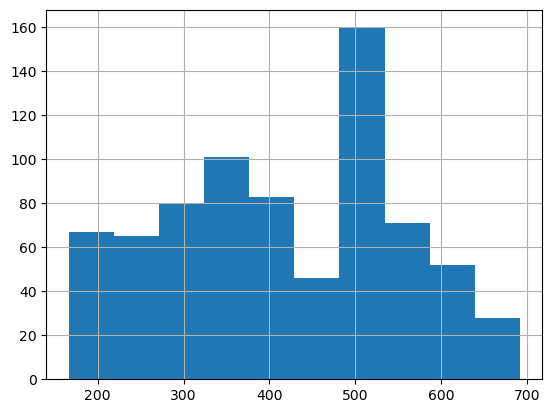

In [10]:
df['Close'].hist()

#### In most of the times the stock will closed at 500

In [11]:
df.set_index('Date',inplace=True)

In [12]:
df

,Close
Date,
2020-10-19,530.719971
2020-10-20,525.419983
2020-10-21,489.049988
2020-10-22,485.230011
2020-10-23,488.279999
...,...
2023-10-10,373.320007
2023-10-11,365.929993
2023-10-12,361.200012


<Axes: xlabel='Date'>

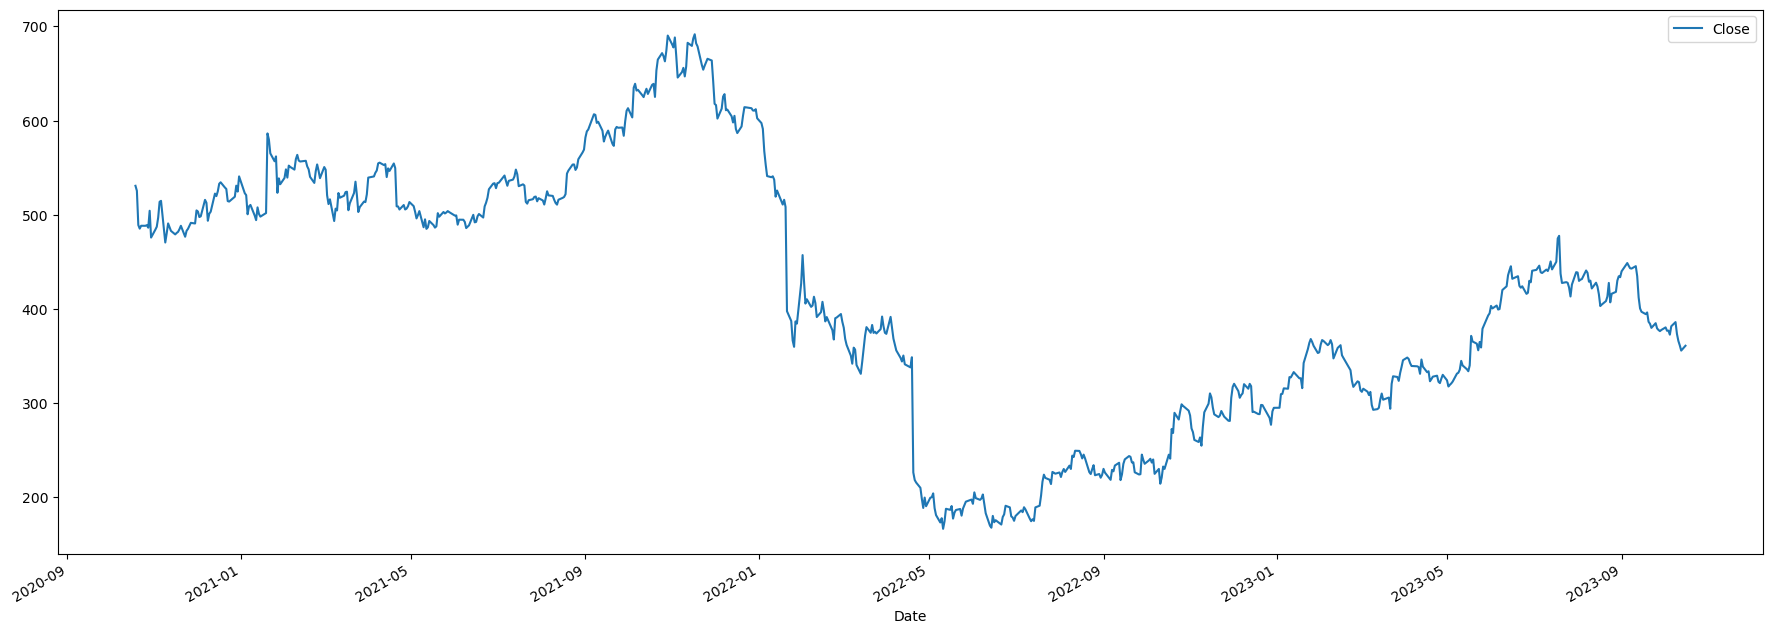

In [13]:
df.plot(figsize=(22,8))

In [14]:
result=seasonal_decompose(df['Close'],model='multiplicative',period=22)

#### Here period=22 is given because in index the date is not continuous. In a week only 5 days are trading period,in a month approximately 20-22 days are trading period

<Axes: xlabel='Date'>

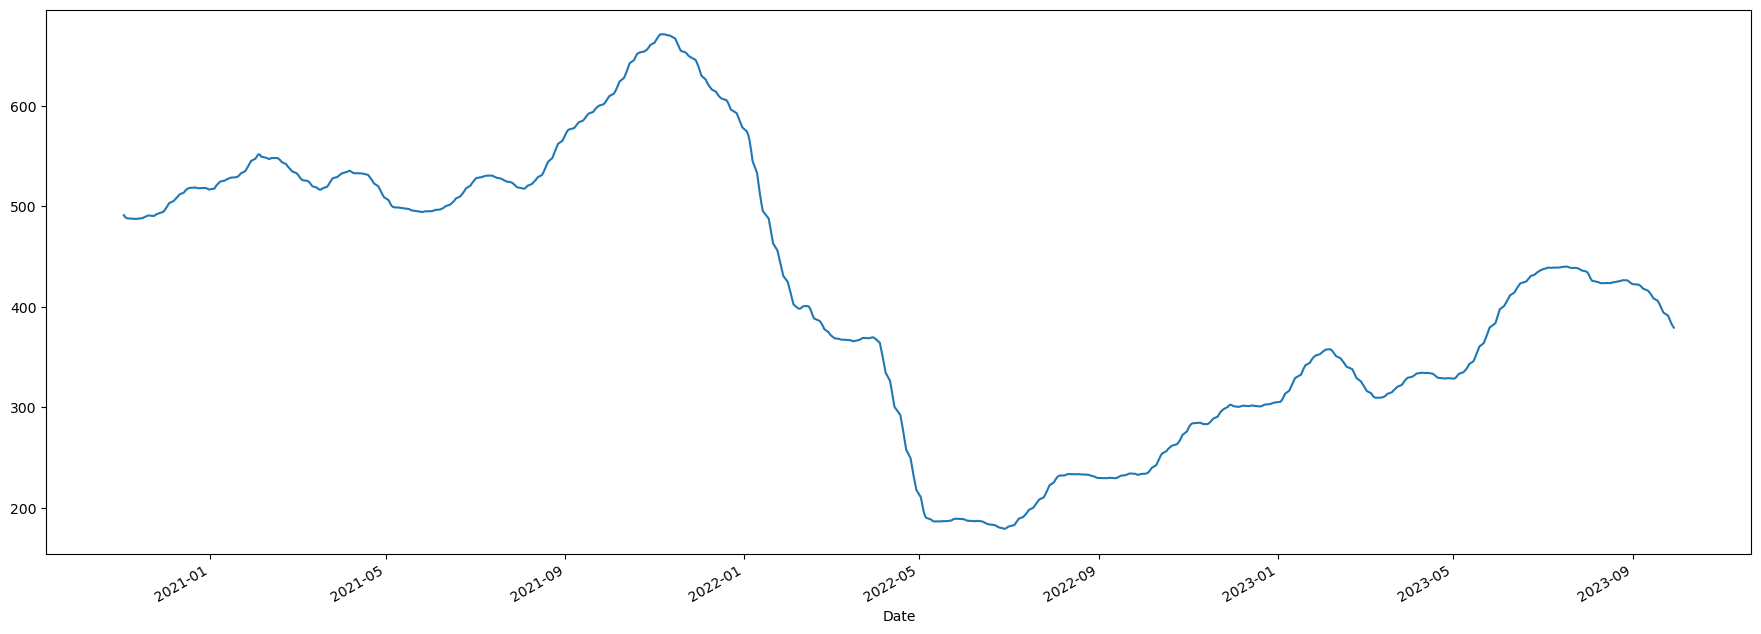

In [15]:
result.trend.plot(figsize=(22,8))

#### Here the trend is decreasing

# 

<Axes: xlabel='Date'>

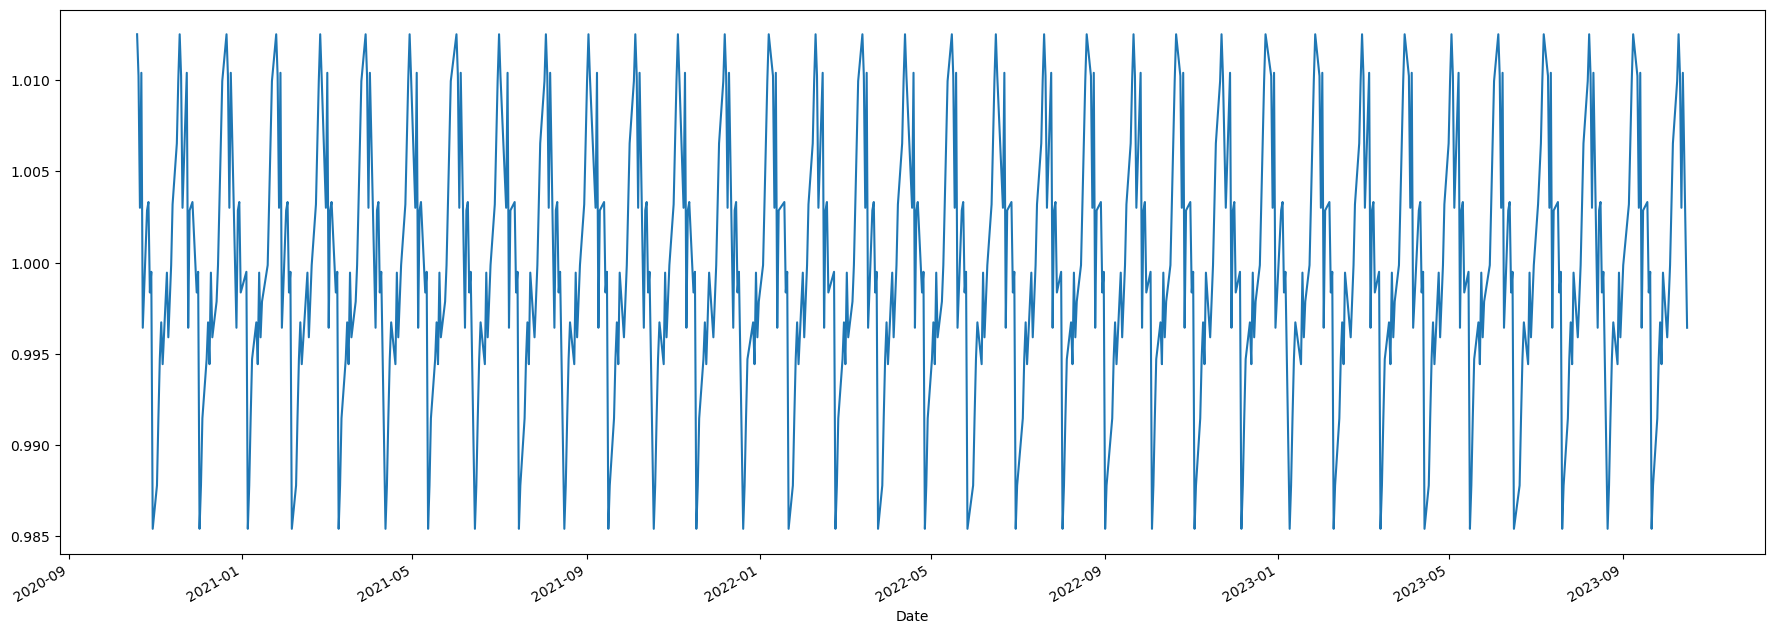

In [16]:
result.seasonal.plot(figsize=(22,8))

#### Data is Seasonal

#

<Axes: xlabel='Date'>

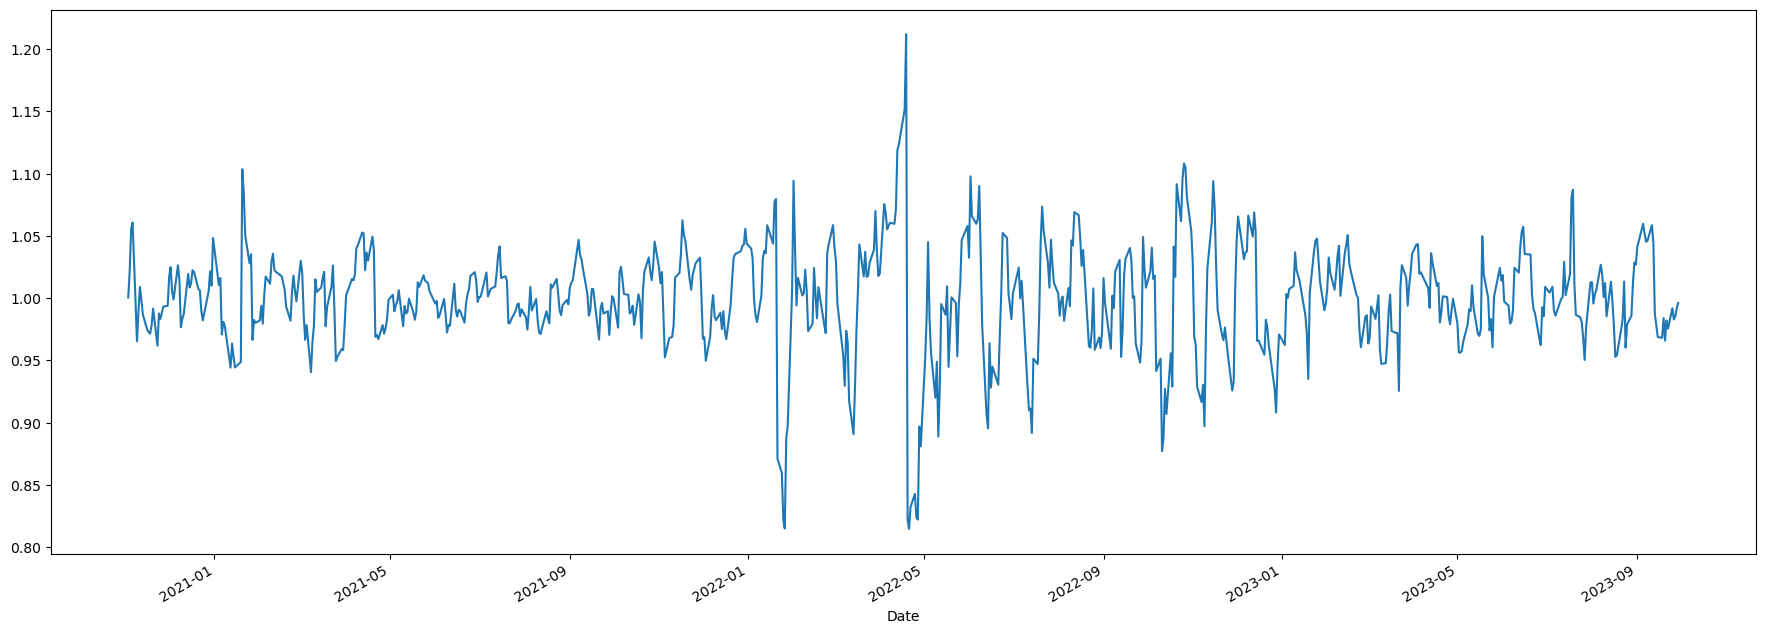

In [17]:
result.resid.plot(figsize=(22,8))

#### Data contain some noise in the year 2022

#

#### Check wether the data is stationary or not by using Adfuller Test

#### let us assume
#### H0 - Data is not stationary
#### H1 - Data is stationary

In [18]:
test=adfuller(df)
output=pd.Series(test[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
output

Test Statistic                  -1.320806
p-value                          0.619601
#Lags Used                       0.000000
Number of Observations Used    752.000000
dtype: float64

#### P-value is greater then critical value we accept null Hypothisis
#### Hence data is not stationary

#

#### To make data stationary we are using differencing method

###### *Differencing

In [19]:
diff=df.diff()
diff

,Close
Date,
2020-10-19,NaN
2020-10-20,-5.299988
2020-10-21,-36.369995
2020-10-22,-3.819977
2020-10-23,3.049988
...,...
2023-10-10,-12.630005
2023-10-11,-7.390014
2023-10-12,-4.729981


In [20]:
original_series = diff.cumsum()

In [21]:
original_series

,Close
Date,
2020-10-19,NaN
2020-10-20,-5.299988
2020-10-21,-41.669983
2020-10-22,-45.489960
2020-10-23,-42.439972
...,...
2023-10-10,-157.399964
2023-10-11,-164.789978
2023-10-12,-169.519959


In [22]:
original_series = original_series + 530.719971


In [23]:
original_series

,Close
Date,
2020-10-19,NaN
2020-10-20,525.419983
2020-10-21,489.049988
2020-10-22,485.230011
2020-10-23,488.279999
...,...
2023-10-10,373.320007
2023-10-11,365.929993
2023-10-12,361.200012


In [24]:
diff.dropna(inplace=True)
diff.head()

,Close
Date,
2020-10-20,-5.299988
2020-10-21,-36.369995
2020-10-22,-3.819977
2020-10-23,3.049988
2020-10-26,-0.040009


#### Check wether the data is stationary or not by using Adfuller Test
#### let us assume
#### H0 - Data is not stationary
#### H1 - Data is stationary

In [25]:
test=adfuller(diff)
output=pd.Series(test[0:4],index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
output

Test Statistic                 -26.634567
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    751.000000
dtype: float64

#### P-value is lesser then critical value. So we reject null Hypothisis
#### Hence data is stationary

<Axes: xlabel='Date'>

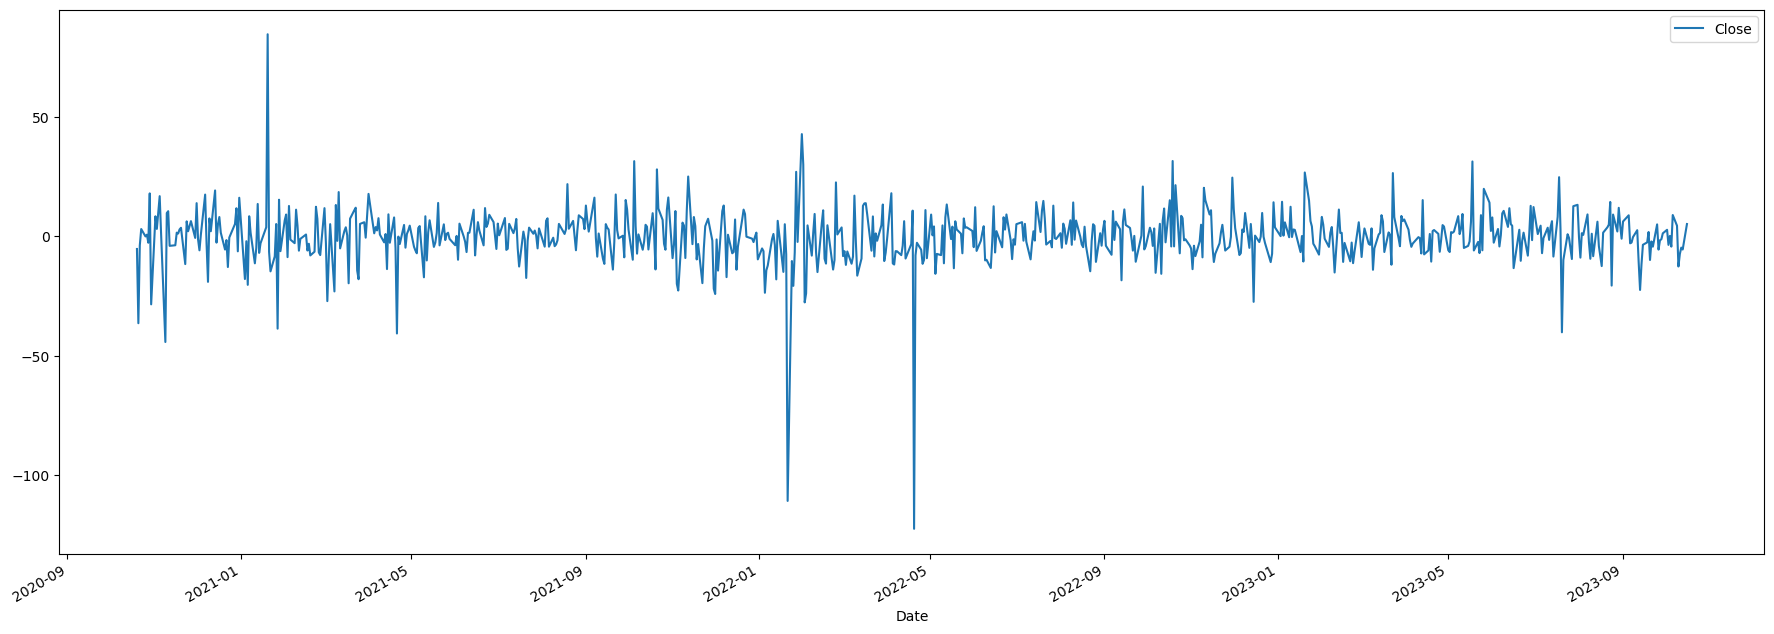

In [26]:
diff.plot(figsize=(22,8))

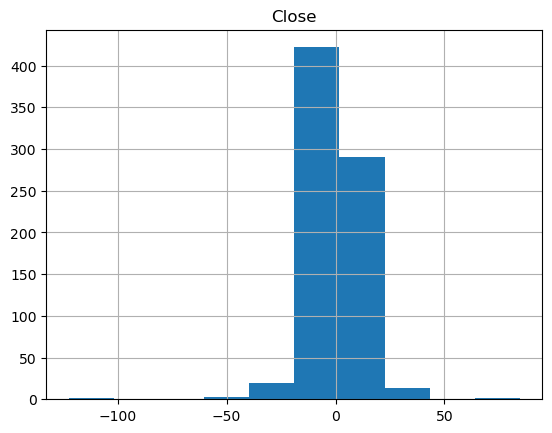

In [27]:
diff.hist()
plt.show()

# 

#### In order to check optimal P and q value we plot pacf and acf plots

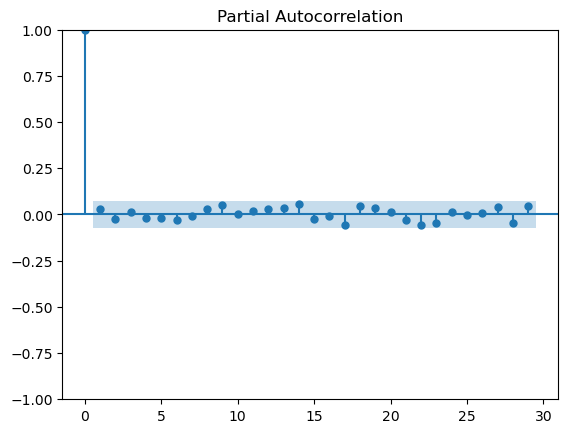

In [28]:
pacf=plot_pacf(diff)

#### p = 0 to 1

# 

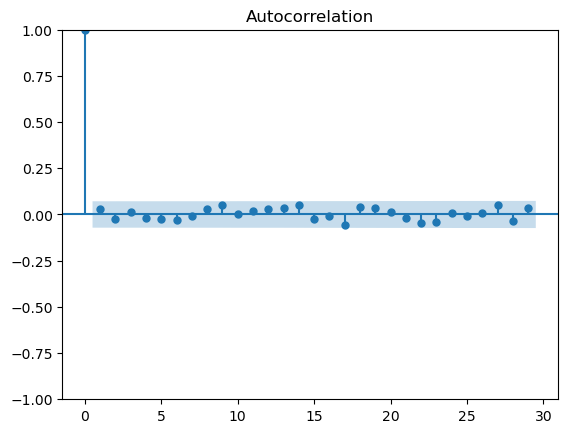

In [29]:
acf=plot_acf(diff)

#### q = 0 to 1

# 

#

## SARIMA

In [32]:
model=sm.tsa.SARIMAX(diff,order=(1,1,1),seasonal_order=(1,1,1,22))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [33]:
results=model.fit()

In [34]:
pred=results.predict(start=diff.index[500],end=diff.index[-1])

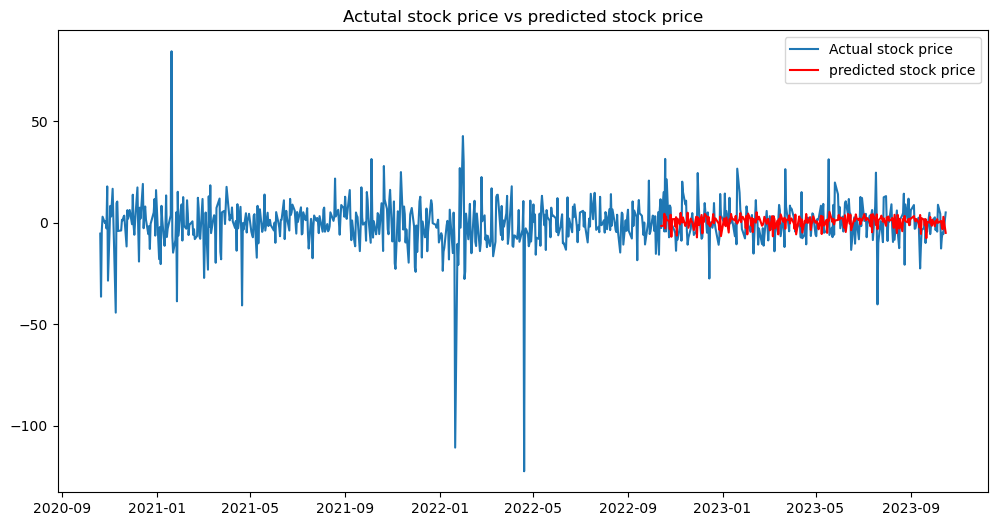

In [35]:
plt.figure(figsize=(12,6))
plt.plot(diff,label='Actual stock price')
plt.plot(pred,label='predicted stock price',color='red')
plt.legend()
plt.title('Actutal stock price vs predicted stock price')
plt.show()

In [36]:
rmse=np.sqrt(mean_squared_error(diff[500:],pred))

In [37]:
rmse

9.242665922827307

#

#

## ARIMA

In [42]:
model=sm.tsa.ARIMA(diff[500:],order=(1,1,1))

C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [43]:
result=model.fit()

In [44]:
pred=result.predict(start=diff.index[500],end=diff.index[-1])

In [45]:
rmse=np.sqrt(mean_squared_error(diff[500:],pred))
rmse

9.033970244772377

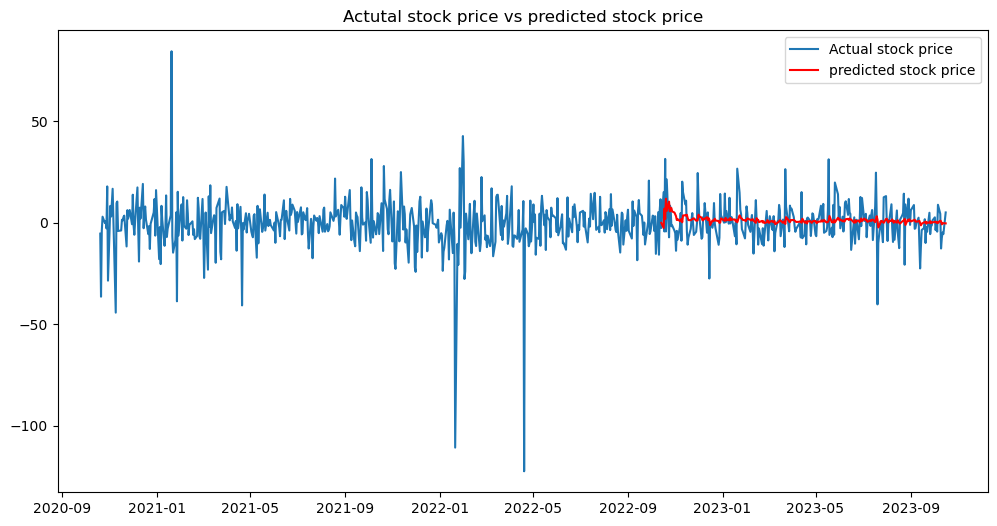

In [46]:
plt.figure(figsize=(12,6))
plt.plot(diff,label='Actual stock price')
plt.plot(pred,label='predicted stock price',color='red')
plt.legend()
plt.title('Actutal stock price vs predicted stock price')
plt.show()